In [1]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar

# math and data
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [2]:
scratch_path = '/glade/u/home/zcleveland/scratch/'
plot_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/time_series/'
temp_scratch_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/temp/'

In [3]:
# define list of variables

# surface instantaneous variables
sfc_instan_list = [
    'sd',  # snow depth  (m of water equivalent)
    'msl',  # mean sea level pressure (Pa)
    'tcc',  # total cloud cover (0-1)
    'stl1',  # soil temp layer 1 (K)
    'stl2',  # soil temp layer 2 (K)
    'stl3',  # soil temp layer 3 (K)
    'stl4',  # soil temp layer 4 (K)
    'swvl1',  # soil volume water content layer 1 (m^3 m^-3)
    'swvl2',  # soil volume water content layer 2 (m^3 m^-3)
    'swvl3',  # soil volume water content layer 3 (m^3 m^-3)
    'swvl4',  # soil volume water content layer 4 (m^3 m^-3)
    '2t',  # 2 meter temp (K)
    '2d',  # 2 meter dew point (K)
    'ishf',  # instant surface heat flux (W m^-2)
    'ie',  # instant moisture flux (kg m^-2 s^-1)
    'cape',  # convective available potential energy (J kg^-1)
    'tcw',  # total column water (kg m^-2) -- sum total of solid, liquid, and vapor in a column
    'sstk',  # sea surface temperature (K)
    'vipile',  # vertical integral of potential, internal, and latent energy (J m^-2) - instan
    'viwve',  # vertical integral of eastward water vapour flux (kg m^-1 s^-1) - instan -- positive south -> north
    'viwvn',  # vertical integral of northward water vapour flux (kg m^-1 s^-1) - instan -- positive west -> east
    'viwvd',  # vertical integral of divergence of moisture flux (kg m^-2 s^-1) - instan -- positive divergencve
]

# surface accumulation variables
sfc_accumu_list = [
    'lsp',  # large scale precipitation (m of water)
    'cp',  # convective precipitation (m of water)
    'tp',  # total precipitation (m of water) -- DERIVED
    'sshf',  # surface sensible heat flux (J m^-2)
    'slhf',  # surface latent heat flux (J m^-2)
    'ssr',  # surface net solar radiation (J m^-2)
    'str',  # surface net thermal radiation (J m^-2)
    'sro',  # surface runoff (m)
    'sf',  # total snowfall (m of water equivalent)
    'ssrd',  # surface solar radiation downwards (J m^-2)
    'strd',  # surface thermal radiation downwards (J m^-2)
    'ttr',  # top net thermal radiation (OLR, J m^-2) -- divide by time (s) for W m^-2
]

# pressure level variables
pl_var_list = [
    # 'pv',  # potential vorticity (K m^2 kg^-1 s^-1)
    # 'crwc',  # specific rain water content (kg kg^-1)
    # 'cswc',  # specific snow water content (kg kg^-1)
    'z',  # geopotential (m^2 s^2)
    't',  # temperature (K)
    'u',  # u component of wind(m s^-1)
    'v',  # v component of wind (m s^-1)
    'q',  # specific humidity (kg kg^-1)
    'w',  # vertical velo|city (Pa s^-1)
    # 'vo',  # vorticity - relative (s^-1)
    # 'd',  # divergence (s^-1)
    'r',  # relative humidity (%)
    # 'clwc',  # specific cloud liquid water content
    # 'ciwc',  # specific cloud ice water content
    # 'cc',  # fraction of cloud cover (0-1)
]

# NAM variables
NAM_var_list = [
    'onset',
    'retreat',
    'length'
]

In [4]:
var_dict = {
    'sd': 'Snow Depth',
    'msl': 'Mean Sea Level Pressure',
    'tcc': 'Total Cloud Cover',
    'stl1': 'Soil Temp Layer 1',
    'stl2': 'Soil Temp Layer 2',
    'stl3': 'Soil Temp Layer 3',
    'stl4': 'Soil Temp Layer 4',
    'swvl1': 'Soil Volume Water Content Layer 1',
    'swvl2': 'Soil Volume Water Content Layer 2',
    'swvl3': 'Soil Volume Water Content Layer 3',
    'swvl4': 'Soil Volume Water Content Layer 4',
    '2t': '2 Meter Temp',
    '2d': '2 Meter Dew Point',
    'ishf': 'Instant Surface Heat Flux',
    'ie': 'Instant Moisture Flux',
    'cape': 'Convective Available Potential Energy',
    'tcw': 'Total Column Water',
    'sstk': 'Sea Surface Temperature',
    'vipile': 'vertical integral of potential, internal, and latent energy',
    'viwve': 'vertical integral of eastward water vapour flux',
    'viwvn': 'vertical integral of northward water vapour flux',
    'viwvd': 'vertical integral of divergence of moisture flux',
    'lsp': 'Large Scale Precipitation',
    'cp': 'Convective Precipitation',
    'tp': 'Total Precipitation',
    'sshf': 'Surface Sensible Heat Flux',
    'slhf': 'Surface Latent Heat Flux',
    'ssr': 'Surface Net Solar Radiation',
    'str': 'Surface Net Thermal Radiation',
    'sro': 'Surface Runoff',
    'sf': 'Total Snowfall',
    'ssrd': 'Surface Solar Radiation Downwards',
    'strd': 'Surface Thermal Radiation Downwards',
    'ttr': 'Top Net Thermal Radiation (OLR)',
    'z': 'Geopotential',
    't': 'Temperature',
    'u': 'U Component of Wind',
    'v': 'V Component of Wind',
    'q': 'Specific Humidity',
    'w': 'Vertical Velocity',
    'r': 'Relative Humidity',
    'onset': 'Onset',
    'retreat': 'Retreat',
    'length': 'Length'
}

In [5]:
var_units = {
    'sd': '(m)',
    'msl': '(Pa)',
    'tcc': '(0-1)',
    'stl1': '(K)',
    'stl2': '(K)',
    'stl3': '(K)',
    'stl4': '(K)',
    'swvl1': '$(m^3 m^{-3})$',
    'swvl2': '$(m^3 m^{-3})$',
    'swvl3': '$(m^3 m^{-3})$',
    'swvl4': '$(m^3 m^{-3})$',
    '2t': '(K)',
    '2d': '(K)',
    'ishf': '$(W m^{-2})$',
    'ie': '$(kg m^{-2} s^{-1})$',
    'cape': '$(J kg^{-1})$',
    'tcw': '$(kg m^{-2})$',
    'sstk': '(K)',
    'vipile': '$(J m^{-2})$',
    'viwve': '$(kg m^{-1} s^{-1})$',
    'viwvn': '$(kg m^{-1} s^{-1})$',
    'viwvd': '$(kg m^{-2} s^{-1})$',
    'lsp': '(m)',
    'cp': '(m)',
    'tp': '(m)',
    'sshf': '$(J m^{-2})$',
    'slhf': '$(J m^{-2})$',
    'ssr': '$(J m^{-2})$',
    'str': '$(J m^{-2})$',
    'sro': '(m)',
    'sf': '(m)',
    'ssrd': '$(J m^{-2})$',
    'strd': '$(J m^{-2})$',
    'ttr': '$(J m^{-2})$',
    'z': '$(m^2 s^{-2})$',
    't': '(K)',
    'u': '$(m s^{-1})$',
    'v': '$(m s^{-1})$',
    'q': '$(kg kg^{-1})$',
    'w': '$(Pa s^{-1})$',
    'r': '(%)',
    'onset': '',
    'retreat': '',
    'length': ''
}

In [6]:
# dictionary of regions and their names
region_avg_dict = {
    'cp': 'Colorado Plateau',
    'mr': 'Mogollon Rim',
    'son': 'Sonoran Desert',
    'chi': 'Chihuahuan Desert',
    'moj': 'Mojave Desert',
    'MeNmAz': 'Mexico, New Mexico, and Arizona Border',
}

# dictionary of regions and their coordinate boundaries
# [WEST, EAST, NORTH, SOUTH] -- WEST and EAST are on 0-360 latitude grid system
region_avg_coords = {
    'cp': [249, 253, 39, 35],
    'mr': [249, 251, 33, 34],
    'son': [246, 250, 28, 32],
    'chi': [252, 256, 29, 33],
    'moj': [243, 247, 33, 37],
    'MeNmAz': [246, 256, 38, 28],
}

# dictionary of colors for the plot of each region
region_colors_dict = {
    'cp': 'blue',
    'mr': 'darkorange',
    'son': 'green',
    'chi': 'red',
    'moj': 'purple',
    'MeNmAz': 'brown',
}

In [5]:
# define a funciton to plot a time series of ERA5 vs ESA soil moisture over the Colorado Plateau
def plot_timeseries_sm_cp(overwrite_flag=False):
    # create out filename and path -- check existence
    out_fn = 'ERA5_ESA_sm_cp_ts.png'
    out_fp = os.path.join(plot_out_path, out_fn)

    if overwrite_flag:
        pass
    elif os.path.exists(out_fp):
        print(f'{out_fn} already exists.  Set overwrite_flag=True to overwrite.')
        print('Skipping . . .\n')
        return
    else:
        print(f'Starting plot for {out_fn}')

    # get file path for datasets
    era_file = f'{scratch_path}ERA5/cp/swvl1_198001_201912_cp.nc'
    regrid_file = f'{scratch_path}ERA5/cp/swvl1_regrid_198001_2019_cp.nc'
    esa_file = f'{scratch_path}ESA_data/cp/sm_esa_198001_201912_cp.nc'

    # open datasets
    era_ds = xr.open_dataset(era_file)
    regrid_ds = xr.open_dataset(regrid_file)
    esa_ds = xr.open_dataset(esa_file)

    # set up figure
    plt.figure(figsize=(12,6))
    era_ds['SWVL1_AVG_CP'].plot(label='Original ERA5 Data', color='r')
    # regrid_ds['SWVL1_AVG_CP'].plot(label='Regrid ERA5 data', color='b')
    esa_ds['sm_CP'].plot(label='ESA Data', color='g')
    plt.title('ERA5 vs. ESA\nSoil Moisture')
    plt.legend()
    plt.xlabel('Time (months)')
    plt.ylabel('Soil Moisture Content (m$^3$ m$^{-3}$)')
    plt.tight_layout()
    plt.savefig(out_fp, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()

Starting plot for ERA5_regrid_ESA_sm_cp.png


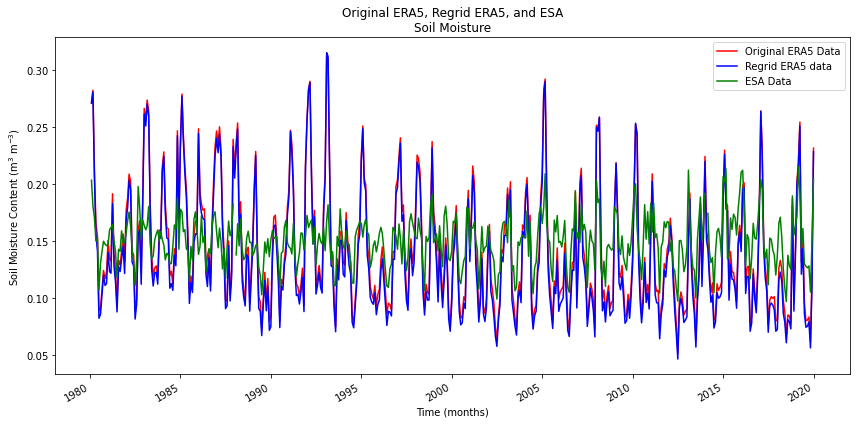

In [6]:
plot_timeseries_sm_cp(overwrite_flag=False)

In [ ]:
# define a function to plot a time series of given variables
def plot_time_series_region(var, region_list, months=None, **kwargs):

    # set start_date and end_date if user not specified
    start_date = kwargs.get('start_date', 198001)
    end_date = kwargs.get('end_date', 201912)

    # split start and end date to get year and month
    start_year, start_month = f'{start_date}'[:4], f'{start_date}'[4:]
    end_year, end_month = f'{end_date}'[:4], f'{end_date}'[4:]

    # open datasets based on type/region
    data_list = []
    for region in region_list:
        if ((var in sfc_instan_list) or (var in sfc_accumu_list)):
            da = open_sfc_data(var, region, **kwargs)
        elif var in pl_var_list:
            da = open_pl_data(var, region, **kwargs)
        else:
            print('something went wrong with var or region')
        data_list.append(da)

In [ ]:
# define a function to turn a list of integers into months
def month_num_to_name(months):

    # make string for month letters from var_range (e.g. [6,7,8] -> 'JJA')
    if len(months) == 1:
        var_months = calendar.month_name[months[0]]  # use full month name if only 1 month
    elif ((len(months) > 1) & (len(months) <= 12)):
        var_months = ''.join([calendar.month_name[m][0] for m in months])
    return var_months

In [ ]:
# define a function to open surface level data
def open_sfc_data(var, region, **kwargs):

    # kwargs
    start_date = kwargs.get('start_date', 198001)
    end_date = kwargs.get('end_date', 201912)

    # split start and end date to get year and month
    start_year, start_month = f'{start_date}'[:4], f'{start_date}'[4:]
    end_year, end_month = f'{end_date}'[:4], f'{end_date}'[4:]
    time_range = np.arange(int(start_year), int(end_year)+1)

    # grab files for var
    if region == 'dsw':
        files = glob.glob(os.path.join(my_era5_path, region, f'*/{var}_*_dsw.nc'))

    elif region in region_avg_dict:
        files = glob.glob(os.path.join(my_era5_path, region, f'{var}_198001_201912_{region}.nc'))

    else:
        print('something went wrong with region in sfc opener')
        return

    files.sort()
    ds = xr.open_mfdataset(files)
    var_name = [v for v in ds.data_vars.keys() if f'{var.upper()}' in v][0]
    da = ds[var_name].sel(time=ds['time.year'].isin(time_range))

    return da

In [ ]:
# define a function to open pressure level data
def open_pl_data(var, region, **kwargs):

    # kwargs
    start_date = kwargs.get('start_date', 198001)
    end_date = kwargs.get('end_date', 201912)
    if 'p_level' not in kwargs:
        print('p_level not specified, p_level=700 will be used')
    p_level = kwargs.get('p_level', 700)

    # split start and end date to get year and month
    start_year, start_month = f'{start_date}'[:4], f'{start_date}'[4:]
    end_year, end_month = f'{end_date}'[:4], f'{end_date}'[4:]
    time_range = np.arange(int(start_year), int(end_year)+1)

    # grab files for var
    if region == 'dsw':
        files = glob.glob(os.path.join(my_era5_path, region, f'*/pl/{var}_*_dsw.nc'))

    elif region in region_avg_dict:
        files = glob.glob(os.path.join(my_era5_path, region, f'{var}_198001_201912_{region}.nc'))

    else:
        print('something went wrong with region in pl opener')
        return

    files.sort()
    ds = xr.open_mfdataset(files)
    var_name = f'{var.upper()}_{region.upper()}'
    da = ds[var_name].sel(time=ds['time.year'].isin(time_range), level=p_level)

    return da